# Compare the DOA algorithems


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## Phased array for detection af 2 signals


In [4]:
class PhasedArray:
    def __init__(self, ant_num, dist_between_ant, wave_lambda):
        self.mAntNum = ant_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda

    def GetSamples(self, inVec0, theta0, inVec1 = None, theta1 = None):
        outMatrix = []
        theta0 = np.deg2rad(theta0)
        phasesVec0 = np.exp(2j * np.sin(theta0) * self.mDistBetweenAnt * np.pi * np.arange(self.mAntNum) / self.mLambda)
        outMatrix = phasesVec0[:, np.newaxis] * inVec0[np.newaxis, :]
        if inVec1 is not None and theta1 is not None:
            theta1 = np.deg2rad(theta1)
            phasesVec1 = np.exp(2j * np.sin(theta1) * self.mDistBetweenAnt * np.pi * np.arange(self.mAntNum) / self.mLambda)
            outMatrix += phasesVec1[:, np.newaxis] * inVec1[np.newaxis, :]
        return(outMatrix)


## Autocorrelation

In [6]:
class RCalculator:
    def __init__(self, antenna_number, mode, alpha = None):
        self.mAntNum = antenna_number
        self.mR = np.zeros((self.mAntNum, self.mAntNum))
        self.mAlpha = alpha
        self.mMode = mode
        if mode == "alpha filter":
          if self.mAlpha is None:
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              print("R calculator - Inset alpha value in the constructor !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              exit()
          if np.abs(self.mAlpha) > 1:
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - Alpha must be less then 1 !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()
        elif mode != "avarage":
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - mode is not valid -> choose alpha filter or avarage !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()

    def GetSamples(self, inMatrix):
        if self.mMode == "alpha filter":
          for i in range(inMatrix.shape[1]):
              #print(inMatrix[:,i])
              lastSampVec = inMatrix[:,i].reshape(inMatrix.shape[0], 1)
              R = lastSampVec @ lastSampVec.T
              self.mR = (1 - self.mAlpha) * self.mR + self.mAlpha * R
        else:
              self.mR = np.dot(inMatrix, inMatrix.conj().T) / inMatrix.shape[1]
        return self.mR

## DOA algorithems

### Delay-and-Sum algorithm

In [9]:
class DS:
  def __init__(self, ant_num, dist_between_ant, wave_lambda):
    self.mAntNum = ant_num
    self.mDistBetweenAnt = dist_between_ant
    self.mLambda = wave_lambda

  def GetSamples(self,R, theta_scan=np.arange(-90, 91, 1)):   
    #making the wieght vector
    ant_indices = np.arange(self.mAntNum).reshape(-1, 1)  # shape (N, 1)
    sin_theta = np.sin(np.radians(theta_scan)).reshape(1, -1)         # shape (1, M)
    phase_shifts = 2j * np.pi * (self.mDistBetweenAnt / self.mLambda) * ant_indices @ sin_theta  # (N, M)
    W = np.exp(phase_shifts)  # shape (N, M), each column is a steering vector

    #applying the algorithem
    Power = np.diag(W.conj().T @ R @ W) # shape (M, 1)
    results = 10 * np.log10(np.abs(Power) + 1e-6)
    results -= np.max(results)
    return results, theta_scan

  def PlotTheResult(self,results, theta_scan):
    plt.plot(theta_scan * 180 / np.pi, results) # lets plot angle in degrees
    plt.xlabel("Theta [Degrees]")
    plt.ylabel("DOA Metric")
    plt.grid()
    plt.show()



### MVDR algorithm

In [11]:
class MVDR:
  def __init__(self, ant_num, dist_between_ant, wave_lambda):
    self.mAntNum = ant_num
    self.mDistBetweenAnt = dist_between_ant
    self.mLambda = wave_lambda

  def GetSamples(self, R, theta_scan=np.arange(-90, 91, 1)):
    #making the wieght vector
    ant_indices = np.arange(self.mAntNum).reshape(-1, 1)  # shape (N, 1)
    sin_theta = np.sin(np.radians(theta_scan)).reshape(1, -1)         # shape (1, M)
    phase_shifts = 2j * np.pi * (self.mDistBetweenAnt / self.mLambda) * ant_indices @ sin_theta  # (N, M)
    W = np.exp(phase_shifts)  # shape (N, M), each column is a steering vector
    
    #applying the algorithem
    R_inv = np.linalg.inv(R)
    Power= 1/(np.diag(W.conj().T @ R_inv @ W) + 1e-6) #make sure there is no zeros
    results = 10 * np.log10(np.abs(Power) + 1e-6)
    results -= np.max(results)
    return results, theta_scan

  def PlotTheResult(self,results, theta_scan):
    plt.plot(theta_scan* 180 / np.pi, results) # lets plot angle in degrees
    plt.xlabel("Theta [Degrees]")
    plt.ylabel("DOA Metric")
    plt.grid()
    plt.show()



### MUSIC algorithem
Interface:
- Init(ant_num, dist_between_ant, wave_lambda)
- GetSamples(inMatrix, scanAnglesDeg=np.arange(-90, 91, 1), signal_count=1) - returns vectors of power (per angle) and angles (corisponding to the power vector)


In [13]:
class MusicDoa:
    def __init__(self, ant_num, dist_between_ant, wave_lambda):
        self.mNumberOfAntennas = ant_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda
        self.mPower = None
        self.mAngles = None

    def GetSamples(self, R, scanAnglesDeg=np.arange(-90, 91, 1), signal_count=1):
        eigvals, eigvecs = np.linalg.eigh(R)
        noise_eigvecs = eigvecs[:, :-signal_count]  #vectors with the smallest eigen valuse
        angles = scanAnglesDeg
        power = []
        for theta_deg in angles:
            theta = np.deg2rad(theta_deg)
            steering_vec = np.exp(2j * np.pi * self.mDistBetweenAnt * np.sin(theta) * np.arange(self.mNumberOfAntennas) / self.mLambda).reshape(-1, 1)
            power.append(1.0 / np.linalg.norm(np.dot(noise_eigvecs.conj().T, steering_vec))**2)
        power = np.abs(power)
        power /= np.max(power)
        power_db = 10 * np.log(power + 1e-6)
        self.mPower = power_db
        self.mAngles = angles
        return angles, power_db

    def PlotPower(self):
        plt.plot(self.mAngles, self.mPower)
        plt.xlabel("Theta [Degrees]")
        plt.ylabel("DOA power calculation")
        plt.grid()
        plt.show()

### Find peaks

In [15]:
class PeaksFinder:

    def __init__(self):
        self.mPeaksNum = None
        self.mInitDone = False

    def Init(self, peaks_num): #Move to constructor
        self.mPeaksNum = peaks_num
        if self.mPeaksNum < 1:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - Enter at least one peak to find !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        self.mInitDone = True

    def GetSamples(self, power_values, scanAnglesDeg):
        if not self.mInitDone:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXXxXxXxXXxXxXxXx")
            print("Peaks finder - Must init before usage !!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXXxXxXxXXxXxXxXx")
            exit()
        peaksIdx = find_peaks(np.squeeze(power_values))[0]
        if len(peaksIdx) == 0:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - No maximum points found !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        if self.mPeaksNum > len(peaksIdx):
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - Didnt found anoth maximum points !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
            exit()
        peaksPowers = power_values[peaksIdx]
        sortedIndices = np.argsort(peaksPowers)[::-1]
        topPeaksIdx = peaksIdx[sortedIndices[:self.mPeaksNum]]
        return scanAnglesDeg[topPeaksIdx]

## Test Bunch

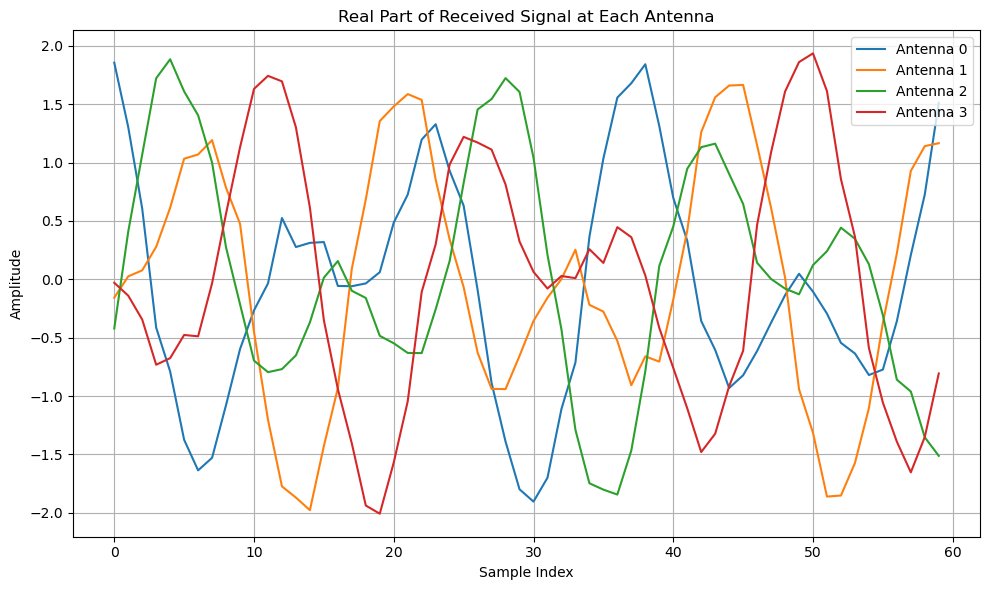

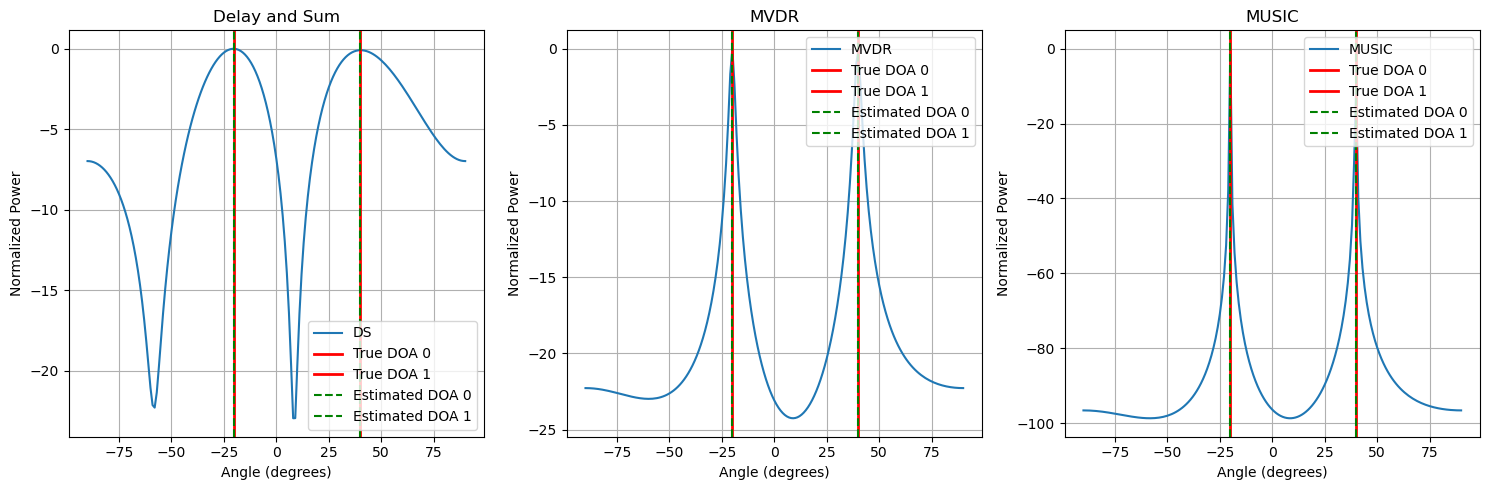

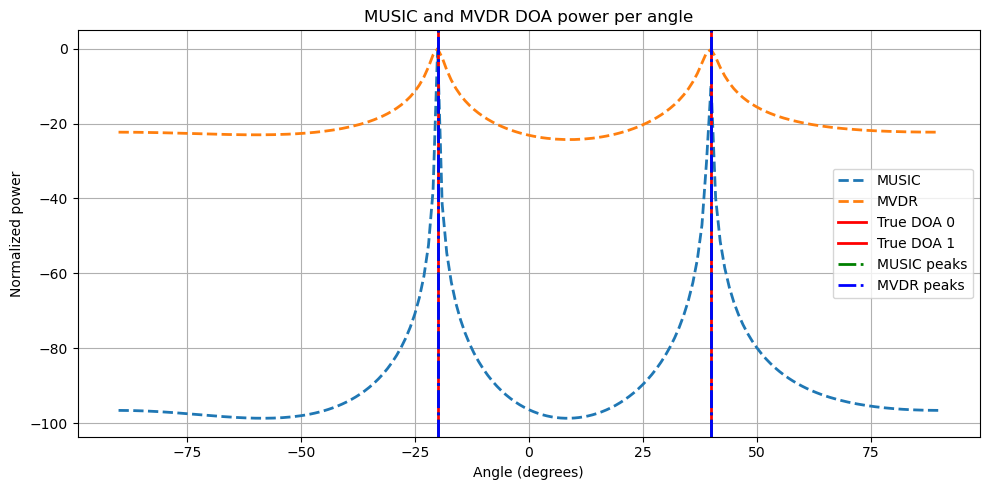

In [17]:
# Test Parameters
num_antennas = 4
num_of_samples = 60
wavelength = 1.0
d = wavelength / 2

#the signal
t = np.linspace(1, num_of_samples, num_of_samples)
signal0 = np.exp(1j * 2 * np.pi * 0.05 * t)
angle0 = -20
signal1 = np.exp(1j * 2 * np.pi * 0.08 * t)
angle1 = 40

# Phased array to simulate received signals
pa = PhasedArray(num_antennas, d, wavelength)
received_matrix = pa.GetSamples(signal0, angle0, signal1, angle1)

# Add some noise
noise_power = 0.1
received_matrix += noise_power * (np.random.randn(*received_matrix.shape) + 1j * np.random.randn(*received_matrix.shape))# shpae

# Calc R
R_Calculator = RCalculator(num_antennas, "avarage")
R = R_Calculator.GetSamples(received_matrix)

#Apply DS
ds=DS(num_antennas, d, wavelength)
power_ds,angles_dr= ds.GetSamples(R)

# Apply MVDR
mvdr = MVDR(num_antennas, d, wavelength)
power_mvdr, angles_mvdr = mvdr.GetSamples(R)

# Apply MUSIC
music = MusicDoa(num_antennas, d, wavelength)
angles_music, power_music = music.GetSamples(R, signal_count=2)

# Extract maximum
peaksFinder = PeaksFinder()
peaksFinder.Init(2)
dsPeacks= peaksFinder.GetSamples(power_ds,angles_dr)
mvdrPeacks = peaksFinder.GetSamples(power_mvdr, angles_mvdr)
musicPeacks = peaksFinder.GetSamples(power_music, angles_music)

# Plot - phased array output
plt.figure(figsize=(10, 6))
for i in range(received_matrix.shape[0]):
    plt.plot(np.real(received_matrix[i]), label=f"Antenna {i}")
plt.title("Real Part of Received Signal at Each Antenna")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot each algorithm in subplots for comparison
plt.figure(figsize=(15, 5))

# DS subplot
plt.subplot(1, 3, 1)
plt.plot(angles_dr, power_ds, label="DS")
plt.axvline(x=angle0, color='r', linestyle='-', linewidth=2, label="True DOA 0")
plt.axvline(x=angle1, color='r', linestyle='-', linewidth=2, label="True DOA 1")
plt.axvline(x=dsPeacks[0], color='g', linestyle='--', label="Estimated DOA 0")
plt.axvline(x=dsPeacks[1], color='g', linestyle='--', label="Estimated DOA 1")
plt.title("Delay and Sum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power")
plt.grid(True)
plt.legend()

# MVDR subplot
plt.subplot(1, 3, 2)
plt.plot(angles_mvdr, power_mvdr, label="MVDR")
plt.axvline(x=angle0, color='r', linestyle='-', linewidth=2, label="True DOA 0")
plt.axvline(x=angle1, color='r', linestyle='-', linewidth=2, label="True DOA 1")
plt.axvline(x=mvdrPeacks[0], color='g', linestyle='--', label="Estimated DOA 0")
plt.axvline(x=mvdrPeacks[1], color='g', linestyle='--', label="Estimated DOA 1")
plt.title("MVDR")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power")
plt.grid(True)
plt.legend()

# MUSIC subplot
plt.subplot(1, 3, 3)
plt.plot(angles_music, power_music, label="MUSIC")
plt.axvline(x=angle0, color='r', linestyle='-', linewidth=2, label="True DOA 0")
plt.axvline(x=angle1, color='r', linestyle='-', linewidth=2, label="True DOA 1")
plt.axvline(x=musicPeacks[0], color='g', linestyle='--', label="Estimated DOA 0")
plt.axvline(x=musicPeacks[1], color='g', linestyle='--', label="Estimated DOA 1")
plt.title("MUSIC")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Plot - DOA algorithms performance
plt.figure(figsize=(10, 5))
plt.plot(angles_music, power_music, label="MUSIC", linewidth=2, linestyle='--')
plt.plot(angles_mvdr, power_mvdr, label="MVDR", linewidth=2, linestyle='--')
plt.axvline(x=angle0, color='r', linestyle='-', linewidth=2, label="True DOA 0")
plt.axvline(x=angle1, color='r', linestyle='-', linewidth=2, label="True DOA 1")
for i in range(2):
    if i:
        plt.axvline(x=musicPeacks[i], color='g', linestyle='-.', linewidth=2)
        plt.axvline(x=mvdrPeacks[i], color='b', linestyle='-.', linewidth=2)
    else:
        plt.axvline(x=musicPeacks[i], color='g', linestyle='-.', linewidth=2, label="MUSIC peaks")
        plt.axvline(x=mvdrPeacks[i], color='b', linestyle='-.', linewidth=2, label="MVDR peaks")
plt.title("MUSIC and MVDR DOA power per angle")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized power")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()